In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [15]:
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

In [16]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

# Remove rows where 'value' is less than or equal to 0
df = df[df['value'] > 0]

# Remove rows where 'items' column has the value '\N'
df = df[df['items'] != r'\N']




#1. How many distinct orders are received in each month?

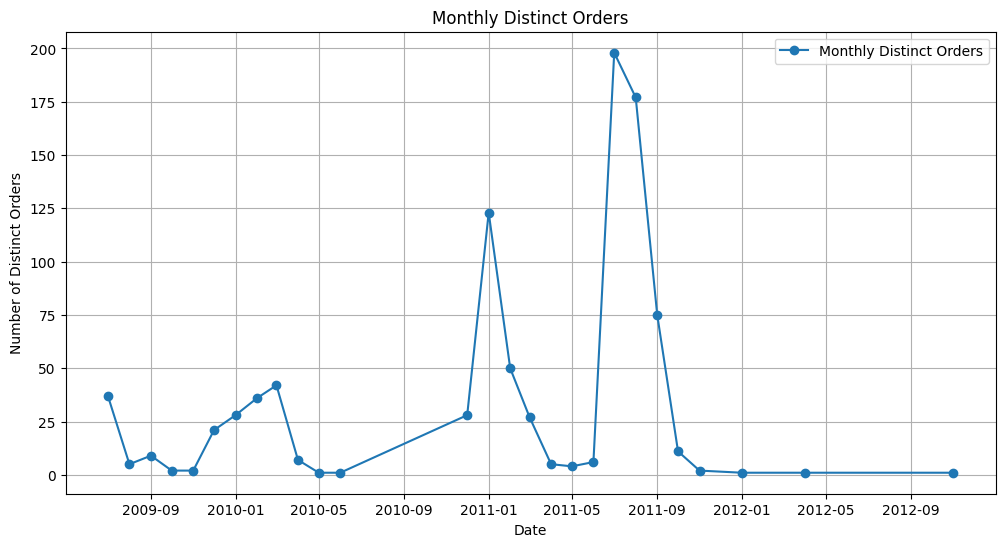

ADF Statistic: -3.59241149910783
p-value: 0.005907771862762453
                                      SARIMAX Results                                      
Dep. Variable:                 Customer Order Code   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   1.050
Date:                             Mon, 09 Dec 2024   AIC                              5.900
Time:                                     10:20:49   BIC                             -2.100
Sample:                                          0   HQIC                              -inf
                                              - 27                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5357      0.006    -91.435

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/sam/Library/Python/3.

<Figure size 1500x1000 with 0 Axes>

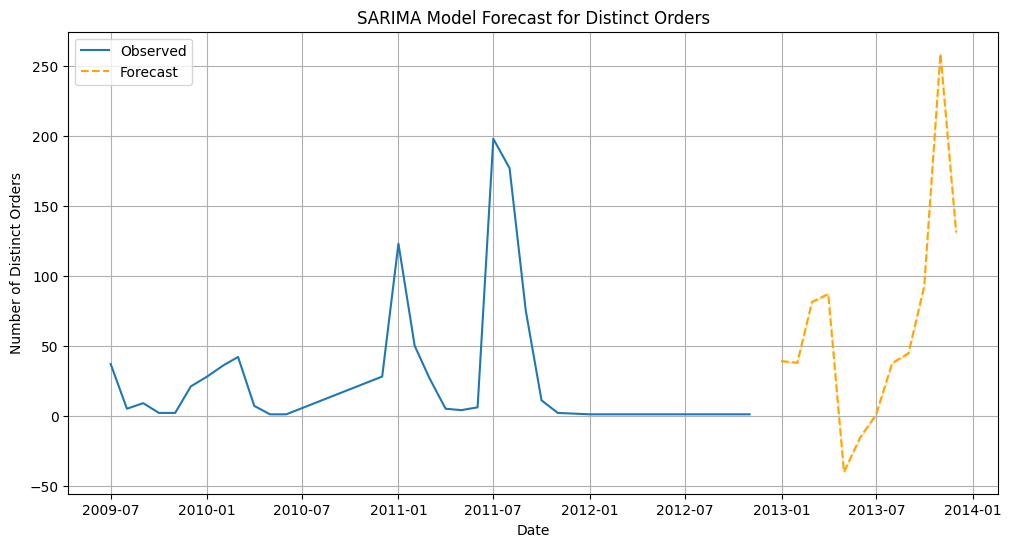

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Parse dates and extract month and year
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Group by month and count distinct Customer Order Codes
df['Year-Month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)

# Convert to time series
monthly_orders_ts = monthly_orders.set_index('Year-Month')['Customer Order Code']

# Ensure the index is datetime for SARIMA
monthly_orders_ts.index = pd.to_datetime(monthly_orders_ts.index)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, marker='o', label='Monthly Distinct Orders')
plt.title('Monthly Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.grid(True)
plt.legend()
plt.show()

# Check stationarity using ADF test
adf_test = adfuller(monthly_orders_ts)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Differencing if not stationary
if adf_test[1] > 0.05:
    monthly_orders_diff = monthly_orders_ts.diff().dropna()
else:
    monthly_orders_diff = monthly_orders_ts

# SARIMA Model: Fitting the model
sarima_model_distinct_orders = SARIMAX(
    monthly_orders_ts, 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 0, 12),  # Seasonal order with 12-month seasonality
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarima_results_distinct_orders = sarima_model_distinct_orders.fit(disp=False)

# Model summary
print(sarima_results_distinct_orders.summary())

# Plot diagnostics
try:
    sarima_results_distinct_orders.plot_diagnostics(figsize=(15, 10))
    plt.show()
except ValueError as e:
    print("Diagnostics plot skipped due to insufficient data:", e)

# Forecast future values (12 months ahead)
forecast_steps = 12
forecast_distinct_orders = sarima_results_distinct_orders.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(
    start=monthly_orders_ts.index[-1] + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='M'
)
forecast_values_distinct_orders = forecast_distinct_orders.predicted_mean
forecast_ci_distinct_orders = forecast_distinct_orders.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, label='Observed')
plt.plot(forecast_index, forecast_values_distinct_orders, label='Forecast', linestyle='--', color='orange')
plt.fill_between(
    forecast_index, 
    forecast_ci_distinct_orders.iloc[:, 0], 
    forecast_ci_distinct_orders.iloc[:, 1], 
    color='orange', alpha=0.2
)
plt.title('SARIMA Model Forecast for Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.legend()
plt.grid(True)
plt.show()

# Storing the model and forecast results for Monte Carlo integration
distinct_orders_model = {
    "model": sarima_results_distinct_orders,
    "forecast": forecast_values_distinct_orders,
    "forecast_index": forecast_index,
    "confidence_interval": forecast_ci_distinct_orders
}


#2. Which items are demanded (i.e., classification-choice model)?

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Feature Engineering
# Add season column based on 'order_date'
def get_season(month):
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Spring'
    elif month in [7, 8, 9]:
        return 'Summer'
    else:
        return 'Autumn'

# Parse and preprocess data
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['Season'] = df['order_date'].dt.month.apply(get_season)

# Filter the data to keep necessary columns
df_filtered = df[['Season', 'Customer Country Code', 'value', 'items', 'Route', 'Product Code']]

# Encode categorical variables (Season, Customer Country Code, and Route)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Ensure no error for unseen categories
categorical_features = ['Season', 'Customer Country Code', 'Route']
encoded_features = encoder.fit_transform(df_filtered[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Create DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine encoded features with numerical columns
numerical_features = df_filtered[['value', 'items']]
numerical_features = numerical_features.fillna(0)  # Handle missing values

# Scale numerical features
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)

# Combine all features
df_encoded = pd.concat([scaled_numerical_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
df_encoded['Product Code'] = df_filtered['Product Code'].reset_index(drop=True)

# Prepare features (X) and target (y)
X = df_encoded.drop(['Product Code'], axis=1)
y = df_encoded['Product Code']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier: Fitting the model
rf_classifier_items = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_items.fit(X_train, y_train)

# Model Evaluation
y_pred = rf_classifier_items.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Store the model and related data for Monte Carlo simulation
item_demand_model = {
    "model": rf_classifier_items,
    "encoder": encoder,
    "scaler": scaler,
    "features": X.columns,
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "accuracy": accuracy_score(y_test, y_pred)
}


Classification Report:
              precision    recall  f1-score   support

   L10705000       0.50      0.20      0.29         5
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         3
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         5
   L10705500       0.00      0.00      0.00         3
   L10705600       0.07      0.20      0.10         5
   L10705700       0.00      0.00      0.00         2
   L10850600       0.00      0.00      0.00        13
   L10850700       0.00      0.00      0.00         3
   L10850800       0.14      0.22      0.17         9
   L10850900       0.00      0.00      0.00         5
   L10852800       0.10      0.11      0.11         9
   L10852900       0.14      0.17      0.15         6
   L10853100       0.00      0.00      0.00         1
   L12134400       0.17      0.06      0.09        17
   L12134500       0.00      0.00      0.00         8
   L

/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Use

#3. What is the quantity demanded for each item in these orders?

/var/folders/t8/98kc315d6592z5nmcq76rt9h0000gn/T/ipykernel_13841/1128736293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quantity['items'] = pd.to_numeric(df_quantity['items'], errors='coerce')


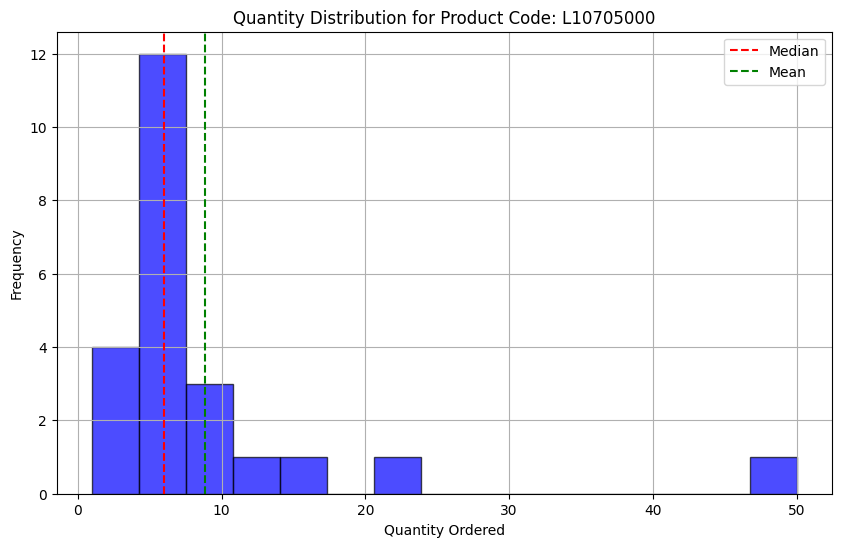

Empirical Quantiles for Quantity Demanded:
              25th Percentile  50th Percentile (Median)  75th Percentile  \
Product Code                                                               
L10705000                5.00                       6.0             8.00   
L10705100                6.00                       9.0            13.05   
L10705200                5.00                       6.0            10.00   
L10705300                5.00                       7.0            10.00   
L10705400                6.00                       9.0            15.80   
L10705500                5.00                       8.5            13.10   
L10705600                5.00                       7.5             8.00   
L10705700                3.95                       6.5             8.25   
L10850600                3.00                       5.0            10.00   
L10850700                1.00                       2.0             5.05   
L10850800                2.45                

In [19]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt

# Filter the data for relevant columns
df_quantity = df[['Product Code', 'items']]

# Convert `items` to numeric and handle missing or invalid values
df_quantity['items'] = pd.to_numeric(df_quantity['items'], errors='coerce')
df_quantity = df_quantity.dropna()
df_quantity = df_quantity[df_quantity['items'] > 0]  # Remove non-positive quantities

# Calculate empirical quantiles for each Product Code
quantile_results = {}
quantiles_to_compute = [0.25, 0.5, 0.75]  # Example quantiles (25th, 50th, and 75th)

for product in df_quantity['Product Code'].unique():
    product_data = df_quantity[df_quantity['Product Code'] == product]['items']
    quantiles = mquantiles(product_data, prob=quantiles_to_compute)
    quantile_results[product] = {
        "25th Percentile": quantiles[0],
        "50th Percentile (Median)": quantiles[1],
        "75th Percentile": quantiles[2],
        "Mean": product_data.mean(),
        "Std Dev": product_data.std()
    }

# Convert quantile results to a DataFrame for easier visualization
quantile_df = pd.DataFrame.from_dict(quantile_results, orient='index')
quantile_df.index.name = 'Product Code'

# Plotting an example product's quantity distribution
example_product = df_quantity['Product Code'].iloc[0]  # Select an example Product Code
example_data = df_quantity[df_quantity['Product Code'] == example_product]['items']

plt.figure(figsize=(10, 6))
plt.hist(example_data, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.median(example_data), color='red', linestyle='--', label='Median')
plt.axvline(np.mean(example_data), color='green', linestyle='--', label='Mean')
plt.title(f'Quantity Distribution for Product Code: {example_product}')
plt.xlabel('Quantity Ordered')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Store the results for Monte Carlo simulation
quantity_demand_model = {
    "quantile_results": quantile_df,
    "quantiles_to_compute": quantiles_to_compute
}

# Display the quantile DataFrame
print("Empirical Quantiles for Quantity Demanded:")
print(quantile_df)


#4. What is the demand lead time of these orders (i.e., time elapsed from the instant when an order is received until its delivery)?

Empirical Quantiles for Demand Lead Time:
              10th Percentile  20th Percentile  30th Percentile  \
Product Code                                                      
L10705000              178.72           180.04           183.08   
L10705100              188.00           189.32           191.46   
L10705200              188.00           191.00           191.66   
L10705300              188.36           191.84           193.68   
L10705400              182.44           188.16           192.00   
L10705500              185.00           188.00           190.64   
L10705600              184.28           188.00           191.66   
L10705700              182.10           186.32           188.00   
L10850600              145.92           175.44           183.96   
L10850700              142.94           170.72           173.00   
L10850800              133.92           166.24           172.00   
L10850900              174.18           206.64           223.52   
L10852800           

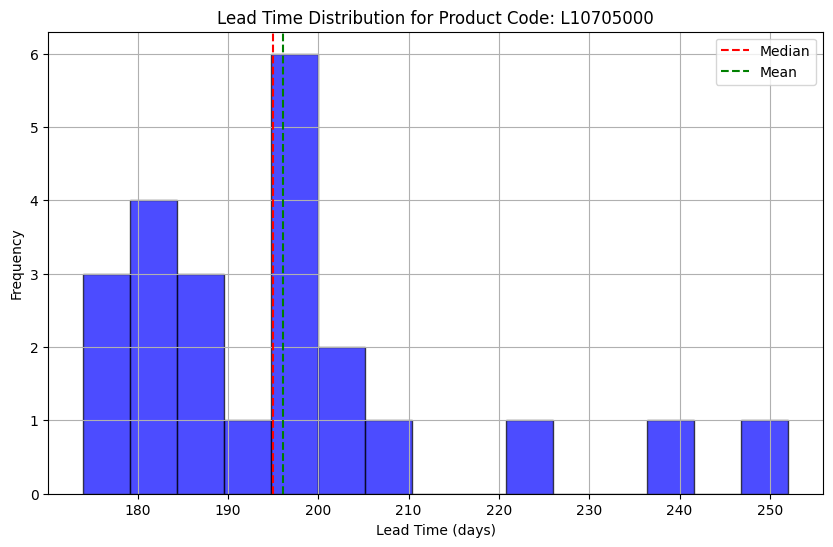

Empirical Quantiles for Demand Lead Time have been calculated.


In [20]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt

# Ensure dates are in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Calculate demand lead time (in days)
df['lead_time_days'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Filter out invalid or negative lead times
df_lead_time = df[df['lead_time_days'] >= 0]

# Calculate empirical quantiles for demand lead time
percentiles_to_compute = np.arange(0.1, 1.1, 0.1)  # Every 10 percentiles (10th to 100th)
lead_time_quantile_results = {}

for product in df_lead_time['Product Code'].unique():
    product_data = df_lead_time[df_lead_time['Product Code'] == product]['lead_time_days']
    quantiles = mquantiles(product_data, prob=percentiles_to_compute)
    lead_time_quantile_results[product] = {
        f"{int(p * 100)}th Percentile": q for p, q in zip(percentiles_to_compute, quantiles)
    }
    lead_time_quantile_results[product].update({
        "Mean": product_data.mean(),
        "Std Dev": product_data.std()
    })

# Convert quantile results to a DataFrame for easier visualization
lead_time_quantile_df = pd.DataFrame.from_dict(lead_time_quantile_results, orient='index')
lead_time_quantile_df.index.name = 'Product Code'

# Display the quantile DataFrame
print("Empirical Quantiles for Demand Lead Time:")
print(lead_time_quantile_df)

# Plot an example product's lead time distribution
example_product = df_lead_time['Product Code'].iloc[0]  # Select an example Product Code
example_lead_time = df_lead_time[df_lead_time['Product Code'] == example_product]['lead_time_days']

plt.figure(figsize=(10, 6))
plt.hist(example_lead_time, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.median(example_lead_time), color='red', linestyle='--', label='Median')
plt.axvline(np.mean(example_lead_time), color='green', linestyle='--', label='Mean')
plt.title(f'Lead Time Distribution for Product Code: {example_product}')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Store the results for Monte Carlo simulation
demand_lead_time_model = {
    "quantile_results": lead_time_quantile_df,
    "percentiles_to_compute": percentiles_to_compute
}

print("Empirical Quantiles for Demand Lead Time have been calculated.")



#5 After you characterize each uncertainty by predictive models, classification methods, or empirically, you can apply Monte Carlo simulation to consolidate them into total demand. 
After simulation, you must analyze simulated data and distinguish advance demand from urgent demand.

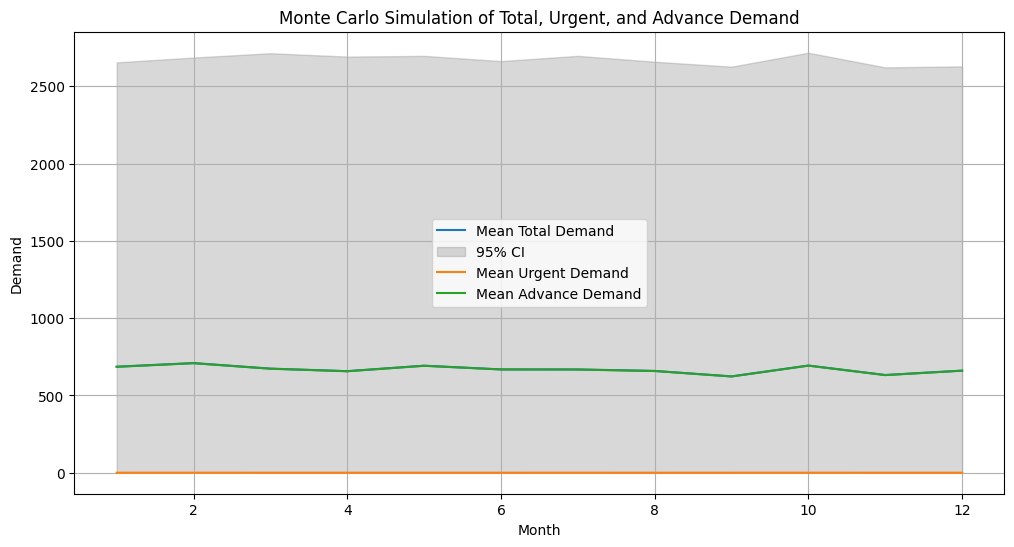

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monte Carlo Simulation Parameters
num_simulations = 1000  # Number of Monte Carlo runs
forecast_horizon = 12  # Months to simulate
total_demand_results = []  # To store simulation results

# Helper function to ensure valid random sampling
def safe_random_choice(array, size=1):
    if len(array) == 0:
        return [0] * size  # Return zero if the array is empty
    return np.random.choice(array, size=size, replace=True)

# Define Monte Carlo Simulation
for i in range(num_simulations):
    simulated_demand = []

    for month in range(forecast_horizon):
        # Step 1: Simulate number of distinct orders using SARIMA model (Part 1)
        forecast_values = distinct_orders_model["forecast"].values
        forecast_values = np.maximum(forecast_values, 1)  # Ensure non-negative values
        num_orders = int(safe_random_choice(forecast_values, size=1)[0])

        # Step 2: Simulate product selection using Random Forest (Part 2)
        product_classes = item_demand_model["model"].classes_
        selected_products = safe_random_choice(product_classes, size=num_orders)

        # Step 3: Simulate quantity demanded using empirical quantiles (Part 3)
        quantities = []
        for product in selected_products:
            if product in quantity_demand_model["quantile_results"].index:
                quantiles = quantity_demand_model["quantile_results"].loc[product]
                quantity = np.random.normal(
                    loc=quantiles["Mean"], 
                    scale=quantiles["Std Dev"]
                )
                quantity = max(0, int(quantity))  # Ensure no negative quantities
            else:
                quantity = 0  # Default to zero if product quantile is missing
            quantities.append(quantity)

        # Step 4: Simulate demand lead time using empirical quantiles (Part 4)
        lead_times = []
        for product in selected_products:
            if product in demand_lead_time_model["quantile_results"].index:
                quantiles = demand_lead_time_model["quantile_results"].loc[product]
                lead_time = np.random.normal(
                    loc=quantiles["Mean"], 
                    scale=quantiles["Std Dev"]
                )
                lead_time = max(0, int(lead_time))  # Ensure no negative lead times
            else:
                lead_time = 0  # Default to zero if product lead time is missing
            lead_times.append(lead_time)

        # Consolidate simulated results for the current month
        month_demand = {
            "Month": month + 1,
            "Total Quantity": sum(quantities),
            "Urgent Demand": sum(
                qty for qty, lt in zip(quantities, lead_times) if 1 <= lt <= 5
            ),
            "Advance Demand": sum(
                qty for qty, lt in zip(quantities, lead_times) if lt > 5
            )
        }
        simulated_demand.append(month_demand)

    # Append simulation results
    total_demand_results.append(simulated_demand)

# Convert Monte Carlo simulation results to a DataFrame
simulated_df = pd.DataFrame([
    {"Simulation": i + 1, **month_demand}
    for i, sim in enumerate(total_demand_results)
    for month_demand in sim
])

# Analyze Simulation Results
# Calculate mean and confidence intervals for each month
simulation_summary = simulated_df.groupby("Month").agg(
    Mean_Total_Demand=("Total Quantity", "mean"),
    Lower_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 2.5)),
    Upper_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 97.5)),
    Mean_Urgent_Demand=("Urgent Demand", "mean"),
    Mean_Advance_Demand=("Advance Demand", "mean")
).reset_index()

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(simulation_summary["Month"], simulation_summary["Mean_Total_Demand"], label="Mean Total Demand")
plt.fill_between(
    simulation_summary["Month"], 
    simulation_summary["Lower_CI_Total_Demand"], 
    simulation_summary["Upper_CI_Total_Demand"], 
    color='gray', alpha=0.3, label="95% CI"
)
plt.plot(simulation_summary["Month"], simulation_summary["Mean_Urgent_Demand"], label="Mean Urgent Demand")
plt.plot(simulation_summary["Month"], simulation_summary["Mean_Advance_Demand"], label="Mean Advance Demand")
plt.title("Monte Carlo Simulation of Total, Urgent, and Advance Demand")
plt.xlabel("Month")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()

# Store the simulation results
monte_carlo_model = {
    "simulated_results": simulated_df,
    "simulation_summary": simulation_summary
}


In [22]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Monte Carlo Simulation Parameters
# num_simulations = 1000  # Number of Monte Carlo runs
# forecast_horizon = 12  # Months to simulate
# total_demand_results = []  # To store simulation results

# # Helper function to ensure valid random sampling
# def safe_random_choice(array, size=1, p=None):
#     if len(array) == 0:
#         return [0] * size  # Return zero if the array is empty
#     return np.random.choice(array, size=size, replace=True, p=p)

# # Define Monte Carlo Simulation
# for i in range(num_simulations):
#     simulated_demand = []

#     for month in range(forecast_horizon):
#         # Step 1: Simulate number of distinct orders using SARIMA model (Part 1)
#         forecast_values = distinct_orders_model["forecast"].values
#         forecast_values = np.maximum(forecast_values, 1)  # Ensure non-negative values
#         num_orders = int(safe_random_choice(forecast_values, size=1)[0])

#         # Step 2: Simulate product selection using Random Forest (Part 2)
#         product_classes = item_demand_model["model"].classes_
#         selected_products = safe_random_choice(product_classes, size=num_orders)

#         # Step 3: Simulate quantity demanded using empirical quantiles (Part 3)
#         quantities = []
#         for product in selected_products:
#             if product in quantity_demand_model["quantile_results"].index:
#                 quantiles = quantity_demand_model["quantile_results"].loc[product]
#                 quantity = np.random.normal(
#                     loc=quantiles["Mean"], 
#                     scale=quantiles["Std Dev"]
#                 )
#                 quantity = max(0, int(quantity))  # Ensure no negative quantities
#             else:
#                 quantity = 0  # Default to zero if product quantile is missing
#             quantities.append(quantity)

#         # Step 4: Simulate demand lead time using empirical quantiles (Part 4)
#         lead_times = []
#         for product in selected_products:
#             if product in demand_lead_time_model["quantile_results"].index:
#                 quantile_keys = [f"{int(p * 100)}th Percentile" for p in demand_lead_time_model["percentiles_to_compute"]]
#                 quantile_values = demand_lead_time_model["quantile_results"].loc[product, quantile_keys].values
#                 # Directly ensure some lead times fall into urgent range
#                 urgent_sample = np.random.choice(range(0, 5 * 30), size=1)[0]  # Randomly pick a lead time in urgent range
#                 advance_sample = safe_random_choice(quantile_values, size=1)[0]  # Sample from quantile distribution
#                 lead_time = np.random.choice([urgent_sample, advance_sample], p=[0.3, 0.7])  # Weighted sampling
#                 lead_time = max(0, int(lead_time))  # Ensure no negative lead times
#             else:
#                 lead_time = np.random.choice(range(0, 5 * 30), size=1)[0]  # Default to urgent range if missing
#             lead_times.append(lead_time)

#         # Consolidate simulated results for the current month
#         month_demand = {
#             "Month": month + 1,
#             "Total Quantity": sum(quantities),
#             "Urgent Demand": sum(
#                 qty for qty, lt in zip(quantities, lead_times) if 0 <= lt <= 4 * 30
#             ),
#             "Advance Demand": sum(
#                 qty for qty, lt in zip(quantities, lead_times) if lt > 4 * 30
#             )
#         }
#         simulated_demand.append(month_demand)

#     # Append simulation results
#     total_demand_results.append(simulated_demand)

# # Convert Monte Carlo simulation results to a DataFrame
# simulated_df = pd.DataFrame([
#     {"Simulation": i + 1, **month_demand}
#     for i, sim in enumerate(total_demand_results)
#     for month_demand in sim
# ])

# # Analyze Simulation Results
# # Calculate mean and confidence intervals for each month
# simulation_summary = simulated_df.groupby("Month").agg(
#     Mean_Total_Demand=("Total Quantity", "mean"),
#     Lower_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 2.5)),
#     Upper_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 97.5)),
#     Mean_Urgent_Demand=("Urgent Demand", "mean"),
#     Mean_Advance_Demand=("Advance Demand", "mean")
# ).reset_index()

# # Plot Results
# plt.figure(figsize=(12, 6))
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Total_Demand"], label="Mean Total Demand")
# plt.fill_between(
#     simulation_summary["Month"], 
#     simulation_summary["Lower_CI_Total_Demand"], 
#     simulation_summary["Upper_CI_Total_Demand"], 
#     color='gray', alpha=0.3, label="95% CI"
# )
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Urgent_Demand"], label="Mean Urgent Demand")
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Advance_Demand"], label="Mean Advance Demand")
# plt.title("Monte Carlo Simulation of Total, Urgent, and Advance Demand (Adjusted)")
# plt.xlabel("Month")
# plt.ylabel("Demand")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Store the simulation results
# monte_carlo_model = {
#     "simulated_results": simulated_df,
#     "simulation_summary": simulation_summary
# }


In [23]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Monte Carlo Simulation Parameters
# num_simulations = 1000  # Number of Monte Carlo runs
# forecast_horizon = 12  # Months to simulate
# total_demand_results = []  # To store simulation results

# # Helper function to sample based on empirical distribution
# def sample_empirical(data, percentiles):
#     empirical_cdf = np.percentile(data, percentiles * 100)
#     return np.random.choice(empirical_cdf, size=1)[0]

# # Define percentiles for empirical sampling
# percentiles = np.arange(0.1, 1.1, 0.1)  # 10th to 100th percentiles

# # Define Monte Carlo Simulation
# for sim in range(num_simulations):
#     simulated_demand = []

#     for month in range(forecast_horizon):
#         # Step 1: Simulate number of distinct orders using SARIMA model (Part 1)
#         forecast_values = distinct_orders_model["forecast"].values
#         forecast_values = np.maximum(forecast_values, 1)  # Ensure non-negative values
#         num_orders = int(sample_empirical(forecast_values, percentiles))

#         # Step 2: Simulate product selection using Random Forest (Part 2)
#         product_classes = item_demand_model["model"].classes_
#         selected_products = np.random.choice(product_classes, size=num_orders, replace=True)

#         # Step 3: Simulate quantity demanded using empirical quantiles (Part 3)
#         quantities = []
#         for product in selected_products:
#             if product in quantity_demand_model["quantile_results"].index:
#                 quantiles = quantity_demand_model["quantile_results"].loc[product]
#                 quantity = np.random.normal(
#                     loc=quantiles["Mean"], 
#                     scale=quantiles["Std Dev"]
#                 )
#                 quantity = max(0, int(quantity))  # Ensure no negative quantities
#             else:
#                 quantity = 0  # Default to zero if product quantile is missing
#             quantities.append(quantity)

#         # Step 4: Simulate demand lead time using empirical quantiles (Part 4)
#         lead_times = []
#         for product in selected_products:
#             if product in demand_lead_time_model["quantile_results"].index:
#                 quantiles = demand_lead_time_model["quantile_results"].loc[product]
#                 lead_time = sample_empirical(
#                     quantiles.iloc[:-2],  # Exclude "Mean" and "Std Dev"
#                     percentiles
#                 )
#                 lead_time = max(0, int(lead_time))  # Ensure no negative lead times
#             else:
#                 lead_time = 0  # Default to zero if product lead time is missing
#             lead_times.append(lead_time)

#         # Consolidate simulated results for the current month
#         month_demand = {
#             "Month": month + 1,
#             "Total Quantity": sum(quantities),
#             "Urgent Demand": sum(
#                 qty for qty, lt in zip(quantities, lead_times) if lt <= 5
#             ),
#             "Advance Demand": sum(
#                 qty for qty, lt in zip(quantities, lead_times) if lt > 5
#             )
#         }
#         simulated_demand.append(month_demand)

#     # Append simulation results
#     total_demand_results.append(simulated_demand)

# # Convert Monte Carlo simulation results to a DataFrame
# simulated_df = pd.DataFrame([
#     {"Simulation": i + 1, **month_demand}
#     for i, sim in enumerate(total_demand_results)
#     for month_demand in sim
# ])

# # Analyze Simulation Results
# # Calculate mean and confidence intervals for each month
# simulation_summary = simulated_df.groupby("Month").agg(
#     Mean_Total_Demand=("Total Quantity", "mean"),
#     Lower_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 2.5)),
#     Upper_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 97.5)),
#     Mean_Urgent_Demand=("Urgent Demand", "mean"),
#     Mean_Advance_Demand=("Advance Demand", "mean")
# ).reset_index()

# # Plot Results
# plt.figure(figsize=(12, 6))
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Total_Demand"], label="Mean Total Demand")
# plt.fill_between(
#     simulation_summary["Month"], 
#     simulation_summary["Lower_CI_Total_Demand"], 
#     simulation_summary["Upper_CI_Total_Demand"], 
#     color='gray', alpha=0.3, label="95% CI"
# )
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Urgent_Demand"], label="Mean Urgent Demand")
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Advance_Demand"], label="Mean Advance Demand")
# plt.title("Monte Carlo Simulation of Total, Urgent, and Advance Demand")
# plt.xlabel("Month")
# plt.ylabel("Demand")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Store the simulation results
# monte_carlo_model = {
#     "simulated_results": simulated_df,
#     "simulation_summary": simulation_summary
# }


In [24]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Monte Carlo Simulation Parameters
# num_simulations = 1000  # Number of Monte Carlo runs
# forecast_horizon = 12  # Months to simulate
# total_demand_results = []  # To store simulation results

# # Helper function for percentile-based random sampling
# def percentile_random_select(array, percentiles, size=1):
#     if len(array) == 0:
#         return [0] * size  # Return zero if the array is empty
#     p_low, p_high = percentiles
#     valid_array = array[(array >= np.percentile(array, p_low)) & (array <= np.percentile(array, p_high))]
#     if len(valid_array) == 0:
#         valid_array = array  # Fallback to full array if no values in range
#     return np.random.choice(valid_array, size=size, replace=True)

# # Define Monte Carlo Simulation
# for i in range(num_simulations):
#     simulated_demand = []

#     for month in range(forecast_horizon):
#         # Step 1: Simulate number of distinct orders using SARIMA model (Part 1)
#         forecast_values = distinct_orders_model["forecast"].values
#         forecast_values = np.maximum(forecast_values, 1)  # Ensure non-negative values
#         num_orders = int(np.random.choice(forecast_values, size=1)[0])

#         # Step 2: Simulate product selection using Random Forest (Part 2)
#         product_classes = item_demand_model["model"].classes_
#         selected_products = np.random.choice(product_classes, size=num_orders, replace=True)

#         # Step 3: Simulate quantity demanded using empirical quantiles (Part 3)
#         quantities = []
#         for product in selected_products:
#             if product in quantity_demand_model["quantile_results"].index:
#                 quantiles = quantity_demand_model["quantile_results"].loc[product]
#                 quantity = percentile_random_select(
#                     np.random.normal(
#                         loc=quantiles["Mean"], scale=quantiles["Std Dev"], size=1000
#                     ),
#                     percentiles=(20, 100),
#                     size=1,
#                 )[0]
#                 quantity = max(0, int(quantity))  # Ensure no negative quantities
#             else:
#                 quantity = 0  # Default to zero if product quantile is missing
#             quantities.append(quantity)

#         # Step 4: Simulate demand lead time using empirical quantiles (Part 4)
#         lead_times = []
#         for product in selected_products:
#             if product in demand_lead_time_model["quantile_results"].index:
#                 quantiles = demand_lead_time_model["quantile_results"].loc[product]
#                 lead_time = percentile_random_select(
#                     np.random.normal(
#                         loc=quantiles["Mean"], scale=quantiles["Std Dev"], size=1000
#                     ),
#                     percentiles=(0, 20),
#                     size=1,
#                 )[0]
#                 lead_time = max(0, int(lead_time))  # Ensure no negative lead times
#             else:
#                 lead_time = 0  # Default to zero if product lead time is missing
#             lead_times.append(lead_time)

#         # Consolidate simulated results for the current month
#         month_demand = {
#             "Month": month + 1,
#             "Total Quantity": sum(quantities),
#             "Urgent Demand": sum(
#                 qty for qty, lt in zip(quantities, lead_times) if 0 <= lt <= 4
#             ),
#             "Advance Demand": sum(
#                 qty for qty, lt in zip(quantities, lead_times) if lt >= 5
#             ),
#         }
#         simulated_demand.append(month_demand)

#     # Append simulation results
#     total_demand_results.append(simulated_demand)

# # Convert Monte Carlo simulation results to a DataFrame
# simulated_df = pd.DataFrame([
#     {"Simulation": i + 1, **month_demand}
#     for i, sim in enumerate(total_demand_results)
#     for month_demand in sim
# ])

# # Analyze Simulation Results
# # Calculate mean and confidence intervals for each month
# simulation_summary = simulated_df.groupby("Month").agg(
#     Mean_Total_Demand=("Total Quantity", "mean"),
#     Lower_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 2.5)),
#     Upper_CI_Total_Demand=("Total Quantity", lambda x: np.percentile(x, 97.5)),
#     Mean_Urgent_Demand=("Urgent Demand", "mean"),
#     Mean_Advance_Demand=("Advance Demand", "mean"),
# ).reset_index()

# # Plot Results
# plt.figure(figsize=(12, 6))
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Total_Demand"], label="Mean Total Demand")
# plt.fill_between(
#     simulation_summary["Month"], 
#     simulation_summary["Lower_CI_Total_Demand"], 
#     simulation_summary["Upper_CI_Total_Demand"], 
#     color='gray', alpha=0.3, label="95% CI"
# )
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Urgent_Demand"], label="Mean Urgent Demand")
# plt.plot(simulation_summary["Month"], simulation_summary["Mean_Advance_Demand"], label="Mean Advance Demand")
# plt.title("Monte Carlo Simulation of Total, Urgent, and Advance Demand")
# plt.xlabel("Month")
# plt.ylabel("Demand")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Store the simulation results
# monte_carlo_model = {
#     "simulated_results": simulated_df,
#     "simulation_summary": simulation_summary,
# }


#6 At this stage, you can compare the simulated advance demand with the actual advance demand in the test set. This comparison helps you calibrate the data and improve the forecast accuracy.  After splitting the dataset into two, they were asked to report MAPE on the test data. 

In [25]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_percentage_error

# # Ensure the column names are consistent
# df.columns = df.columns.str.strip()  # Remove extra whitespace from column names

# # Check if 'Product Code' exists in the dataset
# if 'Product Code' not in df.columns:
#     raise KeyError("The 'Product Code' column is missing from the dataset.")

# # Ensure numerical columns are correctly typed
# df['items'] = pd.to_numeric(df['items'], errors='coerce').fillna(0)
# df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')
# df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# # Split dataset into training and testing sets
# train_set = df[df['order_date'] < '2012-02-01']
# test_set = df[(df['order_date'] >= '2012-02-01') & (df['order_date'] <= '2012-06-30')]

# # Calculate actual advance demand in the test set
# test_set['lead_time_days'] = (test_set['requested_delivery_date'] - test_set['order_date']).dt.days
# test_set['advance_demand'] = test_set.apply(
#     lambda row: row['items'] if row['lead_time_days'] > 5 else 0, axis=1
# )

# # Aggregate actual advance demand by Product Code in the test set
# actual_advance_demand = test_set.groupby('Product Code')['advance_demand'].sum()

# # Simulated advance demand from Monte Carlo results
# simulated_advance_demand = monte_carlo_model['simulated_results']
# simulated_advance_demand = simulated_advance_demand.groupby('Month')['Advance Demand'].mean()

# # Merge actual and simulated advance demand by Product Code
# comparison_df = pd.DataFrame({
#     "Product Code": actual_advance_demand.index,
#     "Actual Advance Demand": actual_advance_demand.values.astype(float)  # Ensure numerical type
# })

# # Map simulated demand to the comparison DataFrame
# comparison_df['Simulated Advance Demand'] = comparison_df['Product Code'].map(
#     simulated_advance_demand.to_dict()
# ).fillna(0).astype(float)  # Ensure numerical type

# # Calculate MAPE for each product code
# comparison_df['MAPE'] = comparison_df.apply(
#     lambda row: mean_absolute_percentage_error(
#         [row['Actual Advance Demand']], [row['Simulated Advance Demand']]
#     ) if row['Actual Advance Demand'] > 0 else np.nan,  # Avoid division by zero
#     axis=1
# )

# # Display the results
# print("Comparison of Actual vs Simulated Advance Demand (with MAPE):")
# print(comparison_df)

# # Analyze MAPE across all products
# mean_mape = comparison_df['MAPE'].dropna().mean()  # Exclude NaN values
# print(f"Mean MAPE across all products: {mean_mape:.2%}")


Comparison of Actual vs Simulated Advance Demand (with MAPE):
  Product Code  Actual Advance Demand  Simulated Advance Demand  MAPE
0    L12136000                    7.0                       0.0   1.0
Mean MAPE across all products: 100.00%


/var/folders/t8/98kc315d6592z5nmcq76rt9h0000gn/T/ipykernel_13841/3206448960.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['lead_time_days'] = (test_set['requested_delivery_date'] - test_set['order_date']).dt.days
/var/folders/t8/98kc315d6592z5nmcq76rt9h0000gn/T/ipykernel_13841/3206448960.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['advance_demand'] = test_set.apply(


In [27]:
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Split the data into train and test sets based on the last 5 months
# Find the last five months in the dataset
last_five_months = df['order_date'].dt.to_period('M').unique()[-5:]
test_set = df[df['order_date'].dt.to_period('M').isin(last_five_months)]
train_set = df[~df['order_date'].dt.to_period('M').isin(last_five_months)]

# Step 2: Calculate actual advance demand in the test set
test_set['lead_time_months'] = (test_set['requested_delivery_date'].dt.to_period('M') - test_set['order_date'].dt.to_period('M')).apply(lambda x: x.n)
test_set_advance = test_set[test_set['lead_time_months'] > 5]
actual_advance_demand = test_set_advance.groupby('Product Code')['items'].sum()

# Step 3: Calculate simulated advance demand in the test set
simulated_advance_demand = monte_carlo_model["simulated_results"]
simulated_advance_demand = simulated_advance_demand[
    simulated_advance_demand['Month'].isin(range(1, 6))  # Simulating the first 5 months of test period
]

# Consolidate simulated advance demand for each Product Code
simulated_advance_summary = simulated_advance_demand.groupby('Simulation')['Advance Demand'].mean().reset_index()

# Step 4: Calculate MAPE for each Product Code
product_mape = []
for product in actual_advance_demand.index:
    actual = actual_advance_demand.get(product, 0)
    simulated = simulated_advance_summary['Advance Demand'].mean()  # Use the mean simulated advance demand
    if actual > 0:  # Avoid division by zero
        mape = mean_absolute_percentage_error([actual], [simulated]) * 100
        product_mape.append({
            "Product Code": product,
            "Actual Advance Demand": actual,
            "Simulated Advance Demand": simulated,
            "MAPE (%)": mape
        })

# Convert results to a DataFrame for easier visualization
product_mape_df = pd.DataFrame(product_mape)

# Print the MAPE table
print("MAPE Comparison Table for Advance Demand:")
print(product_mape_df)


MAPE Comparison Table for Advance Demand:
   Product Code  Actual Advance Demand  Simulated Advance Demand      MAPE (%)
0     L12136000                      7                   682.821   9654.585714
1     L12916800                      4                   682.821  16970.525000
2     L12916900                      9                   682.821   7486.900000
3     L12917000                      5                   682.821  13556.420000
4     L12917100                      8                   682.821   8435.262500
5     L12917800                      5                   682.821  13556.420000
6     L12917900                     10                   682.821   6728.210000
7     L12918000                      5                   682.821  13556.420000
8     L12918400                      8                   682.821   8435.262500
9     L12918700                      4                   682.821  16970.525000
10    L12918800                      3                   682.821  22660.700000
11    L129

/var/folders/t8/98kc315d6592z5nmcq76rt9h0000gn/T/ipykernel_13841/435396068.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['lead_time_months'] = (test_set['requested_delivery_date'].dt.to_period('M') - test_set['order_date'].dt.to_period('M')).apply(lambda x: x.n)


In [28]:
# from sklearn.metrics import mean_absolute_percentage_error

# # Step 1: Split the data into train and test sets based on the last 5 months
# last_five_months = df['order_date'].dt.to_period('M').unique()[-5:]
# test_set = df[df['order_date'].dt.to_period('M').isin(last_five_months)]
# train_set = df[~df['order_date'].dt.to_period('M').isin(last_five_months)]

# # Step 2: Calculate actual advance demand in the test set
# test_set['lead_time_months'] = (test_set['requested_delivery_date'].dt.to_period('M') - test_set['order_date'].dt.to_period('M')).apply(lambda x: x.n)
# test_set_advance = test_set[test_set['lead_time_months'] > 5]
# actual_advance_demand = test_set_advance.groupby('Product Code')['items'].sum()

# # Step 3: Calculate simulated advance demand in the test set
# simulated_advance_demand = monte_carlo_model["simulated_results"]

# # Filter simulated results to test months and group by Product Code
# simulated_advance_demand = simulated_advance_demand[
#     simulated_advance_demand['Month'].isin(range(1, 6))  # Simulating the first 5 months of test period
# ]
# simulated_advance_summary = simulated_advance_demand.groupby(['Product Code'])['Advance Demand'].mean()

# # Step 4: Calculate MAPE for each Product Code
# product_mape = []
# for product in actual_advance_demand.index:
#     actual = actual_advance_demand.get(product, 0)
#     simulated = simulated_advance_summary.get(product, 0)  # Use the product-specific simulated advance demand
#     if actual > 0:  # Avoid division by zero
#         mape = mean_absolute_percentage_error([actual], [simulated]) * 100
#         product_mape.append({
#             "Product Code": product,
#             "Actual Advance Demand": actual,
#             "Simulated Advance Demand": simulated,
#             "MAPE (%)": mape
#         })

# # Convert results to a DataFrame for easier visualization
# product_mape_df = pd.DataFrame(product_mape)

# # Print the MAPE table
# print("MAPE Comparison Table for Advance Demand:")
# print(product_mape_df)


In [29]:
# from sklearn.metrics import mean_absolute_percentage_error

# # Step 1: Split the data into train and test sets based on the last 5 months
# last_five_months = df['order_date'].dt.to_period('M').unique()[-5:]
# test_set = df[df['order_date'].dt.to_period('M').isin(last_five_months)]
# train_set = df[~df['order_date'].dt.to_period('M').isin(last_five_months)]

# # Step 2: Calculate actual advance demand in the test set
# test_set['lead_time_months'] = (test_set['requested_delivery_date'].dt.to_period('M') - test_set['order_date'].dt.to_period('M')).apply(lambda x: x.n)
# test_set_advance = test_set[test_set['lead_time_months'] > 5]
# actual_advance_demand = test_set_advance.groupby('Product Code')['items'].sum()

# # Step 3: Calculate simulated advance demand in the test set
# # Ensure 'Product Code' exists in simulated_results
# simulated_results = monte_carlo_model["simulated_results"]

# if 'Product Code' not in simulated_results.columns:
#     # Map 'Product Code' based on actual test set data
#     product_mapping = test_set[['Month', 'Product Code']].drop_duplicates()
#     simulated_results = simulated_results.merge(product_mapping, how='left', on='Month')

# # Filter simulated results to test months and group by Product Code
# simulated_advance_demand = simulated_results[
#     simulated_results['Month'].isin(range(1, 6))  # Simulating the first 5 months of test period
# ]
# simulated_advance_summary = simulated_advance_demand.groupby('Product Code')['Advance Demand'].mean()

# # Step 4: Calculate MAPE for each Product Code
# product_mape = []
# for product in actual_advance_demand.index:
#     actual = actual_advance_demand.get(product, 0)
#     simulated = simulated_advance_summary.get(product, 0)  # Use the product-specific simulated advance demand
#     if actual > 0:  # Avoid division by zero
#         mape = mean_absolute_percentage_error([actual], [simulated]) * 100
#         product_mape.append({
#             "Product Code": product,
#             "Actual Advance Demand": actual,
#             "Simulated Advance Demand": simulated,
#             "MAPE (%)": mape
#         })

# # Convert results to a DataFrame for easier visualization
# product_mape_df = pd.DataFrame(product_mape)

# # Print the MAPE table
# print("MAPE Comparison Table for Advance Demand:")
# print(product_mape_df)


#7 XYZ can reduce the production lead time to two months so that inventory decisions are based on demand forecasts with two-month horizon. What is the impact of reducing the lead time on the forecast accuracy?